# Machine Learning: Decision Tree

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from IPython.display import display, Latex, Markdown
import matplotlib.pyplot as plt

In [2]:
def cleanCases(gun_cases):
    # gun violence cases dataset cleaned
    cases = pd.read_csv(gun_cases)
    cases = cases.loc[:, ['date', 'state', 'n_killed', 'n_injured']]

    cases['date'] = pd.to_datetime(cases['date'])
    cases['year'] = cases['date'].dt.year
    cases['harmed'] = cases['n_killed'] + cases['n_injured']
    cases = cases.drop(columns=['date', 'n_killed', 'n_injured'])
    cases = cases[(cases['year'] > 2013) & (cases['year'] < 2018)]
    cases = cases.groupby(['state', 'year']).agg('sum')
    cases = cases.reset_index()
    return cases

def cleanLaws(gun_laws):
    # gun laws dataset cleaned
    laws = pd.read_csv(gun_laws)
    laws = laws[(laws['year'] > 2014) & (laws['year'] < 2018)]
    return laws

def cleanPopulation(population):
    # state population dataset cleaned
    #importing state population counts from 2010 - 2019
    state_populations = pd.read_csv(population)

    #cleaning state population data
    state_populations = state_populations.drop(columns=['2010', '2011', '2012', '2013', '2018', '2019'])
    return state_populations

def combineDatasets(gun_cases, gun_laws, population):
    cases = cleanCases(gun_cases)
    laws = cleanLaws(gun_laws)
    state_population = cleanPopulation(population)
    
    # adding population counts to cases dataset by matching year and state
    for i, row in cases.iterrows():
        cases.at[i, ('population')] = float(state_population[state_population.state == row['state']][str(row['year'])])

    #compute the proportion of harmed individuals due to a gun incident out of the state population 
    cases['proportion_harmed'] = cases['harmed']/cases['population']
    cases.drop(columns=['harmed', 'population'], inplace=True)
    # Check if gun cases were reduced based on previous year values (only valid for 2015-2017)
    harmed = cases['proportion_harmed'].tolist()
    decrease = list()

    # False = (Decrease = 0), True = (Decrease = 1)
    for i in range(0, len(harmed), 4):
        decrease.append(False)                           # Year 2014; Temporary Place-Holder
        decrease.append(harmed[i] > harmed[i+1])         # Year 2015
        decrease.append(harmed[i+1] > harmed[i+2])       # Year 2016
        decrease.append(harmed[i+2] > harmed[i+3])       # Year 2017

    cases['decrease_in_gun_violence'] = pd.Series(decrease)
    cases = cases.drop(labels=range(0, len(decrease), 4), axis=0)
    cases = cases[(cases['state'] != 'District of Columbia')]
    
    # Combined dataset
    data = cases.merge(laws, on=['state', 'year'], how='outer')
    return data

In [3]:
gun_cases = 'gun-violence-data_01-2013_03-2018.csv'
gun_laws = 'statefirearmlaws.csv'
population = 'us_states_census.csv'
data = combineDatasets(gun_cases, gun_laws, population)

In [4]:
data.head(5)

,state,year,proportion_harmed,decrease_in_gun_violence,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
0,Alabama,2015,0.000195,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
1,Alabama,2016,0.000257,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
2,Alabama,2017,0.000287,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
3,Alaska,2015,0.000209,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,Alaska,2016,0.000258,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


# Oversampling Dataset

To balance out our decrease_in_gun_violence classes, we oversample from the decrease_in_gun_violence=1 class. 

Oversampling= replicating some points from the minority class in order to increase its cardinality [handling imbalanced datasets](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)

In [26]:
oversampled_rows = data[data.decrease_in_gun_violence == True].copy(deep=True)
balanced_data = pd.concat([data, oversampled_rows], ignore_index=True)

print(f'Shape: {balanced_data.shape}')
print(f'Number of examples in our balanced dataset where decrease_in_gun_violence=0: {len(balanced_data[balanced_data.decrease_in_gun_violence == False])}')
print(f'Number of examples in our balanced dataset where decrease_in_gun_violence=1: {len(balanced_data[balanced_data.decrease_in_gun_violence == True])}')

Shape: (199, 139)
Number of examples in our balanced dataset where decrease_in_gun_violence=0: 101
Number of examples in our balanced dataset where decrease_in_gun_violence=1: 98


# Create the features and labels for classification.

In [32]:
def create_features_labels(dataset): 
    X = dataset.drop(columns = ['decrease_in_gun_violence', 'state', 'year']) #keep all law reform info as features, as well as the proportion of individuals harmed
    y = dataset['decrease_in_gun_violence']   # Labels are if the number of cases reduced
    y = y.replace({True: 1, False: 0})
    return X, y

# X, y = create_features_labels(data)
X, y = create_features_labels(balanced_data)

In [33]:
#checking proportion of classes w.r.t 'decrease'
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=0: {len(y[y == 0])}')
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=1: {len(y[y == 1])}')

Number of examples in our entire dataset where decrease_in_gun_violence=0: 101
Number of examples in our entire dataset where decrease_in_gun_violence=1: 98


# Baseline Classifier

Create a baseline classifier `MajorityLabelClassifier` to test our classifier against. This will always predict the class equal to the mode of the labels.

In [34]:
class MajorityLabelClassifier():
    # Initialize parameter for the classifier
    def __init__(self):
        self.mode = 0
    
    # Fit the data by taking training data X and their labels y and storing the learned parameter
    def fit(self, X, y):
        modes = dict()           # Stores all the modes of the training data
        y = y.tolist()
        for i in range(len(X)):
            if y[i] in modes.keys():
                modes[y[i]] += 1
            else:
                modes[y[i]] = 1
                
        # Find the most frequent mode and store it
        total = 0
        for key in modes:
            if modes[key] > total:
                total = modes[key]
                self.mode = key
    
    # Predict the label for each instance X as the learned parameter
    def predict(self, X):
        labels = list()
        for i in X:
            labels.append(self.mode)
        return labels
    
    # Calculate the accuracy of our classifier using the true and predicted labels
    def evaluate_accuracy(self, y, y_predict):
        accurate_pred = 0
        total = len(y_predict)
        true_labels = y.tolist()
        
        for i in range(total):
            if true_labels[i] == y_predict[i]:
                accurate_pred += 1
        return accurate_pred/total

In [35]:
baseline = MajorityLabelClassifier()
baseline.fit(X, y)
labels = baseline.predict(X)
print(baseline.evaluate_accuracy(y, labels))

0.6838235294117647


# Decision Tree Classifier

Evaluate the `DecisionTreeClassifier()` by training, fitting, and predicting on the data.

`we should use cross validation to fine tune some of our parameters and try to increase our accuracy up to 80%`

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1) #changed split to 80% train, 20% test
clf_model = DecisionTreeClassifier()   
clf_model.fit(X_train,y_train)
y_predict = clf_model.predict(X_test)

Train Accuracy: 0.9346733668341709
Test Accuracy: 0.7
precision: [0.78947368 0.61904762]
recall   : [0.65217391 0.76470588]
f1 score : [0.71428571 0.68421053]


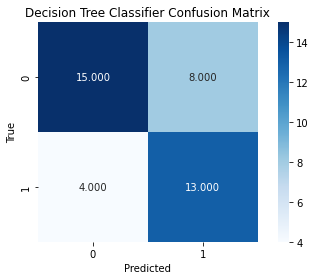

In [37]:
#evaluation metrics
train_accuracy = clf_model.score(X,y)  #this gives training accuracy
test_accuracy = accuracy_score(y_test, y_predict) #this gives testing accuracy

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

cm = confusion_matrix(y_test, y_predict) #confusion matrix
precision, recall, f1, support =  precision_recall_fscore_support(y_test, y_predict) #precision, recall, f1 score, and support for each class (decrease_in_gun_violence=0 and decrease_in_gun_violence=1)

print(f'precision: {precision}')
print(f'recall   : {recall}')
print(f'f1 score : {f1}')

#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues);
plt.ylabel('True');
plt.xlabel('Predicted');
plt.title('Decision Tree Classifier Confusion Matrix');
plt.tight_layout();

`our train accuracy is much higher than our test accuracy --> we may be overfitting: consider (post) pruning the tree`

Our classifier also seems to be performing better for one class (decrease=0) than the other class (decrease=1), as evidenced by a higher preicision and recall scores for decision=0 than decision=1.
This may be due to an imbalance in class labels in our dataset (more decrease=0 than decrease=1), since in our dataset, we have 101 entries where decrease = 0 and only 49 entries where decrease=1.
Also, by looking at the confusion matrix, we see that the correct predicitions for decrease=0 is much higher (11) than the correct predictions for decrease=1 (2). Ideally, they should be pretty balanced.

`update: results after oversampling dataset` (April 18, 2022)

To balance out our classes in our dataset (balanced_data), we oversampled from the decrease_in_gun_violence=1 class and ended up having 101 rows where decrease_in_gun_violence=0 and 98 rows where decrease_in_gun_violence=1. We were able to increase our train and test accuracies, as well as our precision, recall and f1 score metrics. With the balanced dataset, our test accuracy increased from ~43% to ~70%. The precision and recall scores are much more balanced, and we can these results in our confusion matrix for the results of our decision tree classifier, as the number of correctly predicted examples from both classes (decrease=0 and decrease=1) are closely balanced (15 correctly predicted rows from our test set where decrease=0 and 13 correctly predicted rows from our test set where decrease=1).

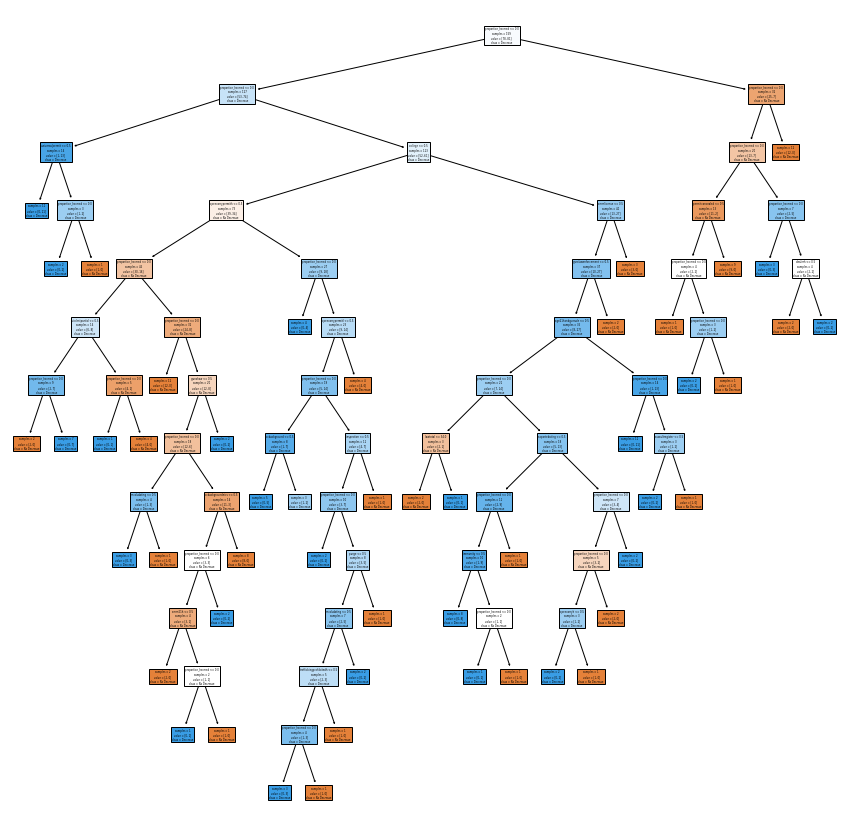

In [38]:
#visualizing decision tree classifier
feature_names_list = list(X.columns) 
plt.figure(figsize=(15,15))
plot_tree(clf_model, feature_names = feature_names_list,  
          class_names = ['No Decrease', 'Decrease'], 
          filled = True, impurity = False); #class names match to `decrease` values [0=did not decrease, 1=did decrease]

# Random Forest Classifier

In [39]:
# Gaussian Classifier
clf = RandomForestClassifier(n_estimators = 100)

#train the model 
clf.fit(X_train, y_train)

#evaluate on test set
y_pred = clf.predict(X_test)

#get accuracy
print("Accuracy of Random Forest Classifier: ", accuracy_score(y_test, y_pred))

Accuracy of Random Forest Classifier:  0.55


Train Accuracy: 0.9045226130653267
Test Accuracy: 0.55
precision: [0.69230769 0.48148148]
recall   : [0.39130435 0.76470588]
f1 score : [0.5        0.59090909]


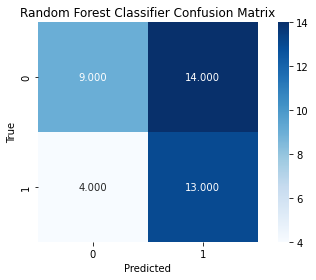

In [41]:
#evaluation metrics
train_accuracy = clf.score(X,y)  #this gives training accuracy
test_accuracy = accuracy_score(y_test, y_pred) #this gives testing accuracy

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

cm = confusion_matrix(y_test, y_pred) #confusion matrix
precision, recall, f1, support =  precision_recall_fscore_support(y_test, y_pred) #precision, recall, f1 score, and support for each class (decrease_in_gun_violence=0 and decrease_in_gun_violence=1)

print(f'precision: {precision}')
print(f'recall   : {recall}')
print(f'f1 score : {f1}')

#plot confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues);
plt.ylabel('True');
plt.xlabel('Predicted');
plt.title('Random Forest Classifier Confusion Matrix');
plt.tight_layout();

To Do (04/02/2022):
- `add state population counts and use proportions instead of raw counts to compare decrease in gun violence`
- `change target label to 'decrease_in_gun_violence'`
- `put MajorityLabelClassifier class in a .py file of its own and just import to avoid going over 5 page limit`
- fine tune parameters on DT using cross validation (ex. depth of decision tree)
- `visualize decisision tree with sklearn function`
- add additional features about participant info such as mean participant age, mean victim age, mean suspect age on a per state/year basis
- `view results using additional metrics namely: accuracy, confusion matrix, f1 score, precision, and recall`

(items in `yellow` have been completed + implemented)

Notes on Performance of Decision Tree (April 03 2022):
- classes are heavily imbalanced (101 rows where there was no decrease in gun violence and 49 rows where there was a decrease in gun violence)
- decision tree is overfitting on our train data: 88% train accuracy, 43% test accuracy

Next steps:
- try using cross validation to fit our tree
- we can try pruning the tree to try and avoid overfitting
- currently unsure how to handle class imbalances in data